In [1]:
import os 
import sys

# append the path of the project to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../src")))
os.chdir("../src")

In [2]:
import pickle
with open("../data/int_to_char_no_stereo_sv_500k.pkl", "rb") as file:
    int_to_char = pickle.load(file)

In [3]:
from src.models import MoleculeAutoEncoderLightning
import numpy as np
import torch


# Load data, model, and necessary mappings
data = np.load("../data/moles_ohe_no_stereo_sv_500k.npy")
data = data[:1000] #working on smaller dataset for testing purposes
char_to_int = {char: i for i, char in int_to_char.items()}

molecule_model = MoleculeAutoEncoderLightning.load_from_checkpoint(
    "../checkpoints/MS-h1-bce_no_Smax/last.ckpt",
    charset_size=33,
    seq_len=72,
    loss="bce",
    int_to_char=int_to_char
)

molecule_model.model.eval()
device = molecule_model.device
molecule_model.model.to(device) #move model to device

batch = torch.tensor(data).float().to(device)

In [4]:
from rdkit import Chem, RDLogger

# Suppress RDKit warnings and errors
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

In [5]:
def one_hot_to_smiles(one_hot, int_to_char):
    """Converts a one-hot tensor to a SMILES string."""
    indices = torch.argmax(one_hot, dim=-1).cpu().numpy()
    smiles = "".join([int_to_char.get(i, "") for i in indices.flatten()]).strip("?^$") #handle potential missing keys
    return smiles

def is_valid_smiles(smiles):
    """Checks if a SMILES string is valid."""
    mol = Chem.MolFromSmiles(smiles)
    return mol is not None

In [6]:
def explore_neighborhood(compound_indices, num_samples):
  """
  Explores the latent space neighborhood of multiple compounds.

  Args:
      compound_indices: A list of indices of compounds in the data to explore.
      num_samples: The number of samples to draw from each compound's neighborhood.

  Returns:
      A dictionary where keys are compound indices and values are success rates.
  """
  success_rates = {}
  for compound_idx in compound_indices:
    compound_ohe = batch[compound_idx].unsqueeze(0).transpose(1, 2)
    latent_vector = molecule_model.model.encode(compound_ohe).cpu().detach()
    success_count = 0

    for _ in range(num_samples):
      random_increment = torch.randn_like(latent_vector) * 0.1  # Adjust scaling factor
      new_latent_vector = latent_vector + random_increment
      decoded_ohe = molecule_model.model.decode(new_latent_vector.to(device)).cpu().detach()
      decoded_smiles = one_hot_to_smiles(decoded_ohe[0], int_to_char)
      if is_valid_smiles(decoded_smiles):
        success_count += 1

    success_rates[compound_idx] = success_count / num_samples
  return success_rates

In [7]:
# Example usage
compound_indices = range(0, 1000, 10)  # List of compound indices to explore
num_samples = 100

success_rates = explore_neighborhood(compound_indices, num_samples)

for idx, rate in success_rates.items():
  print(f"Compound {idx} Neighborhood Success Rate: {rate:.2%}")

Compound 0 Neighborhood Success Rate: 77.00%
Compound 10 Neighborhood Success Rate: 25.00%
Compound 20 Neighborhood Success Rate: 47.00%
Compound 30 Neighborhood Success Rate: 32.00%
Compound 40 Neighborhood Success Rate: 36.00%
Compound 50 Neighborhood Success Rate: 40.00%
Compound 60 Neighborhood Success Rate: 58.00%
Compound 70 Neighborhood Success Rate: 25.00%
Compound 80 Neighborhood Success Rate: 49.00%
Compound 90 Neighborhood Success Rate: 19.00%
Compound 100 Neighborhood Success Rate: 44.00%
Compound 110 Neighborhood Success Rate: 64.00%
Compound 120 Neighborhood Success Rate: 43.00%
Compound 130 Neighborhood Success Rate: 43.00%
Compound 140 Neighborhood Success Rate: 59.00%
Compound 150 Neighborhood Success Rate: 47.00%
Compound 160 Neighborhood Success Rate: 19.00%
Compound 170 Neighborhood Success Rate: 52.00%
Compound 180 Neighborhood Success Rate: 37.00%
Compound 190 Neighborhood Success Rate: 63.00%
Compound 200 Neighborhood Success Rate: 78.00%
Compound 210 Neighborhoo

In [8]:
# average success rate aand std deviation
success_rates_values = list(success_rates.values())
avg_success_rate = np.mean(success_rates_values)
std_dev = np.std(success_rates_values)
print(f"Average Success Rate: {avg_success_rate:.2%}")
print(f"Standard Deviation: {std_dev:.2%}")

Average Success Rate: 48.16%
Standard Deviation: 22.25%


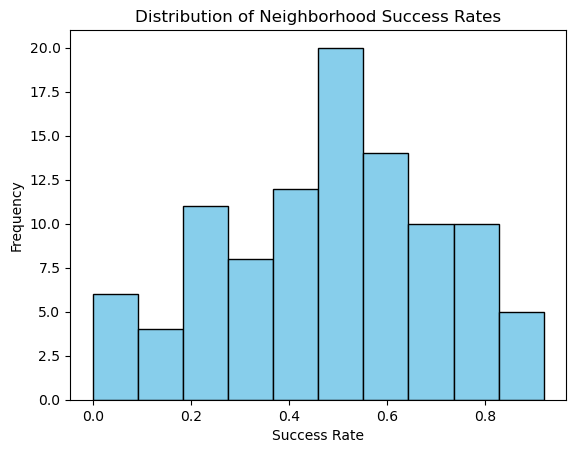

In [9]:
# plot histogram of success rates
import matplotlib.pyplot as plt

plt.hist(success_rates_values, bins=10, color="skyblue", edgecolor="black")
plt.xlabel("Success Rate")
plt.ylabel("Frequency")
plt.title("Distribution of Neighborhood Success Rates")
plt.show()

Compound 1:


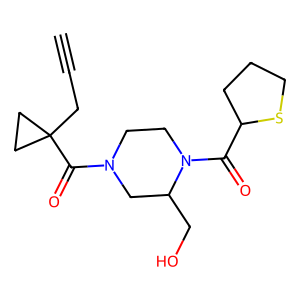

Compound 2:


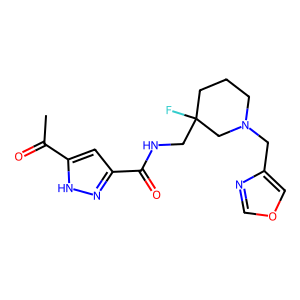

Morph Step 1: C(C#C)C1(C(N2CC(CO)N(C(C3CCCS3)=O)CC2)=O)CC1


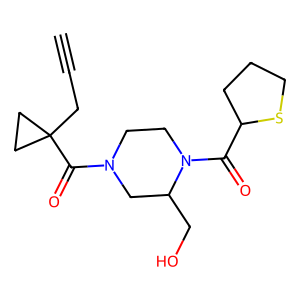

Morph Step 2: C(C#C)C1(C(N2CC(CO)N(C(C3CCCS3)=O)CC2)=O)CC1


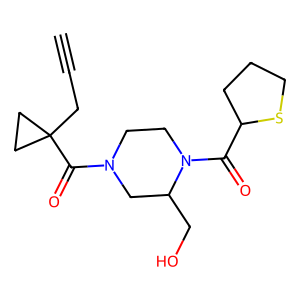

Morph Step 3: C=CCC)C1(C(N2CC(CO)N(CCC3CCCC3)=O)CC2)=O)CC1
Invalid SMILES generated
Morph Step 4: O1COCCC)C1(C(C2(CC(C)NCCCC3CCCC3)=O)OC1)=O)C1C
Invalid SMILES generated
Morph Step 5: CNCCOCCCCCC(N(C2(CO(C==CCCc3ccCC3)=O)OCC2)=OC)C
Invalid SMILES generated
Morph Step 6: C(c1Cc2cccc((N(C2(C)(C=CCCCc3occ33C2O)O)C1)=OC)C
Invalid SMILES generated
Morph Step 7: C(c1cc2cccc((N(C3(C)(C(CC3Ccco3CCCC2)=O)C1)=OC)O
Invalid SMILES generated
Morph Step 8: C(c1cnH]nc(C(NCC3(F)CN(Cc3cocn3)CCC2)=O)c1)(O)=O
Invalid SMILES generated
Morph Step 9: C(c1[nH]nc(C(NCC2(F)CN(Cc3cocn3)CCC2)=O)c1)(C)=O


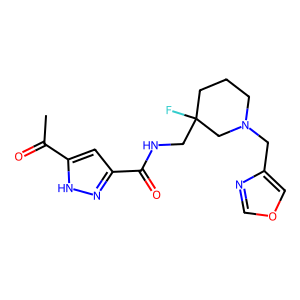

Morph Step 10: C(c1[nH]nc(C(NCC2(F)CN(Cc3cocn3)CCC2)=O)c1)(C)=O


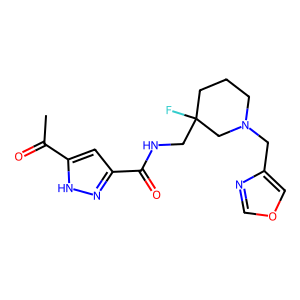

In [10]:
from rdkit.Chem import Draw
# 2. Latent Space Morphing
compound1_idx = 0
compound2_idx = 1

# draw the compounds
mol1 = Chem.MolFromSmiles(one_hot_to_smiles(batch[compound1_idx], int_to_char))
mol2 = Chem.MolFromSmiles(one_hot_to_smiles(batch[compound2_idx], int_to_char))

img1 = Draw.MolToImage(mol1)
img2 = Draw.MolToImage(mol2)

print("Compound 1:")
display(img1)
print("Compound 2:")
display(img2)

compound1_ohe = batch[compound1_idx].unsqueeze(0).transpose(1, 2)
compound2_ohe = batch[compound2_idx].unsqueeze(0).transpose(1, 2)

latent1 = molecule_model.model.encode(compound1_ohe).cpu().detach()
latent2 = molecule_model.model.encode(compound2_ohe).cpu().detach()

morphed_smiles = []

num_morph_steps = 10
for i in range(num_morph_steps):
    alpha = i / (num_morph_steps - 1)
    morphed_latent = (1 - alpha) * latent1 + alpha * latent2
    morphed_ohe = molecule_model.model.decode(morphed_latent.to(device)).cpu().detach()
    morphed_smiles = one_hot_to_smiles(morphed_ohe[0], int_to_char)
    print(f"Morph Step {i+1}: {morphed_smiles}")
    if is_valid_smiles(morphed_smiles):
        mol = Chem.MolFromSmiles(morphed_smiles)
        img = Draw.MolToImage(mol)
        display(img)
    else:
        print("Invalid SMILES generated")